## Part I: On-policy learning and SARSA 
(3 points)

_This notebook builds upon `qlearning.ipynb`, or to be exact, generating qlearning.py._

The policy we're gonna use is epsilon-greedy policy, where agent takes optimal action with probability $(1-\epsilon)$, otherwise samples action at random. Note that agent __can__ occasionally sample optimal action during random sampling by pure chance.

In [1]:
# XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    %env DISPLAY = : 1

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from qlearning import QLearningAgent


class EVSarsaAgent(QLearningAgent):
    """ 
    An agent that changes some of q-learning functions to implement Expected Value SARSA. 
    Note: this demo assumes that your implementation of QLearningAgent.update uses get_value(next_state).
    If it doesn't, please add
        def update(self, state, action, reward, next_state):
            and implement it for Expected Value SARSA's V(s')
    """

    def get_value(self, state):
        """ 
        Returns Vpi for current state under epsilon-greedy policy:
          V_{pi}(s) = sum _{over a_i} {pi(a_i | s) * Q(s, a_i)}

        Hint: all other methods from QLearningAgent are still accessible.
        """
        epsilon = self.epsilon
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return 0.0
        if len(possible_actions) == 0:
            return 0.0

        q_values = [self.get_qvalue(state, (self.get_best_action(state)) * self.get_qvalue(state, action)) for action in possible_actions]
#         q_values = [(self.get_best_action(state) * self.get_qvalue(state, action)) for action in possible_actions]
#         print(q_values)
        
        state_value = np.sum(q_values)
#         print(state_value)

        return state_value

### Cliff World

Let's now see how our algorithm compares against q-learning in case where we force agent to explore all the time.

<img src=https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/cliffworld.png width=600>
<center><i>image by cs188</i></center>

In [3]:
import gym
import gym.envs.toy_text
env = gym.envs.toy_text.CliffWalkingEnv()
n_actions = env.action_space.n

print(env.__doc__)


    This is a simple implementation of the Gridworld Cliff
    reinforcement learning task.

    Adapted from Example 6.6 (page 132) from Reinforcement Learning: An Introduction
    by Sutton and Barto:
    http://incompleteideas.net/book/the-book-2nd.html
    
    With inspiration from:
    https://github.com/dennybritz/reinforcement-learning/blob/master/lib/envs/cliff_walking.py

    The board is a 4x12 matrix, with (using Numpy matrix indexing):
        [3, 0] as the start at bottom-left
        [3, 11] as the goal at bottom-right
        [3, 1..10] as the cliff at bottom-center

    Each time step incurs -1 reward, and stepping into the cliff incurs -100 reward 
    and a reset to the start. An episode terminates when the agent reaches the goal.
    


In [4]:
# Our cliffworld has one difference from what's on the image: there is no wall.
# Agent can choose to go as close to the cliff as it wishes. x:start, T:exit, C:cliff, o: flat ground
env.render()

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T



In [12]:
def play_and_train(env, agent, t_max=10**4):
    """This function should 
    - run a full game, actions given by agent.getAction(s)
    - train agent using agent.update(...) whenever possible
    - return total reward"""

#     global game
    
    total_reward = 0.0
    s = env.reset()

#     game += 1
    
    for t in range(t_max):
        a = agent.get_action(s)

        next_s, r, done, _ = env.step(a)
        
        agent.update(s, a, r, next_s)

        s = next_s
        total_reward += r
        
#         if t % 500 == 0:
#             clear_output(True)
#             env.render()
#             print("game: {}".format(game), "step: {}".format(t), "total reward: {}".format(total_reward))
  
        if done:
            break
        
    return total_reward

In [6]:
from qlearning import QLearningAgent

agent_sarsa = EVSarsaAgent(alpha=0.25, epsilon=0.2, discount=0.99,
                           get_legal_actions=lambda s: range(n_actions))

agent_ql = QLearningAgent(alpha=0.25, epsilon=0.2, discount=0.99,
                          get_legal_actions=lambda s: range(n_actions))

In [10]:
# from IPython.display import clear_output

# game = 0

# for i in range(100):
#     reward = play_and_train(env, agent_sarsa)
    # Note: agent.epsilon stays constant

o  o  o  o  o  o  o  x  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

game: 0 step: 3500 total reward: -4986.0


KeyboardInterrupt: 

EVSARSA mean reward = -5610.89
QLEARNING mean reward = -104.04


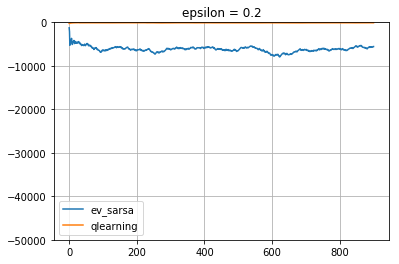

In [14]:
from IPython.display import clear_output
from pandas import DataFrame


def moving_average(x, span=100): return DataFrame(
    {'x': np.asarray(x)}).x.ewm(span=span).mean().values


rewards_sarsa, rewards_ql = [], []

for i in range(1000):
    rewards_sarsa.append(play_and_train(env, agent_sarsa))
    rewards_ql.append(play_and_train(env, agent_ql))
    # Note: agent.epsilon stays constant

    if i % 100 == 0:
        clear_output(True)
        print('EVSARSA mean reward =', np.mean(rewards_sarsa[-100:]))
        print('QLEARNING mean reward =', np.mean(rewards_ql[-100:]))
        plt.title("epsilon = %s" % agent_ql.epsilon)
        plt.plot(moving_average(rewards_sarsa), label='ev_sarsa')
        plt.plot(moving_average(rewards_ql), label='qlearning')
        plt.grid()
        plt.legend()
        plt.ylim(-50000, 0)
        plt.show()

Let's now see what did the algorithms learn by visualizing their actions at every state.

In [15]:
def draw_policy(env, agent):
    """ Prints CliffWalkingEnv policy with arrows. Hard-coded. """
    n_rows, n_cols = env._cliff.shape

    actions = '^>v<'

    for yi in range(n_rows):
        for xi in range(n_cols):
            if env._cliff[yi, xi]:
                print(" C ", end='')
            elif (yi * n_cols + xi) == env.start_state_index:
                print(" X ", end='')
            elif (yi * n_cols + xi) == n_rows * n_cols - 1:
                print(" T ", end='')
            else:
                print(" %s " %
                      actions[agent.get_best_action(yi * n_cols + xi)], end='')
        print()

In [16]:
print("Q-Learning")
draw_policy(env, agent_ql)

print("SARSA")
draw_policy(env, agent_sarsa)

Q-Learning
 >  >  v  >  >  >  >  >  v  >  >  v 
 v  v  >  v  v  v  >  >  >  v  >  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 
SARSA
 v  >  <  >  >  >  >  >  <  <  >  > 
 <  ^  ^  ^  ^  ^  ^  >  <  ^  ^  > 
 ^  >  >  <  >  >  <  ^  ^  >  <  ^ 
 X  C  C  C  C  C  C  C  C  C  C  T 


### More on SARSA

Here are some of the things you can do if you feel like it:

* Play with epsilon. See learned how policies change if you set epsilon to higher/lower values (e.g. 0.75).
* Expected Value SASRSA for softmax policy __(2pts)__:
$$ \pi(a_i|s) = softmax({Q(s,a_i) \over \tau}) = {e ^ {Q(s,a_i)/ \tau}  \over {\sum_{a_j}  e ^{Q(s,a_j) / \tau }}} $$
* Implement N-step algorithms and TD($\lambda$): see [Sutton's book](http://incompleteideas.net/book/bookdraft2018jan1.pdf) chapter 7 and chapter 12.
* Use those algorithms to train on CartPole in previous / next assignment for this week.

### Homework part II: experience replay
(4 points)

There's a powerful technique that you can use to improve sample efficiency for off-policy algorithms: [spoiler] Experience replay :)

The catch is that you can train Q-learning and EV-SARSA on `<s,a,r,s'>` tuples even if they aren't sampled under current agent's policy. So here's what we're gonna do:

<img src=https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/exp_replay.png width=480>

#### Training with experience replay
1. Play game, sample `<s,a,r,s'>`.
2. Update q-values based on `<s,a,r,s'>`.
3. Store `<s,a,r,s'>` transition in a buffer. 
 3. If buffer is full, delete earliest data.
4. Sample K such transitions from that buffer and update q-values based on them.


To enable such training, first we must implement a memory structure that would act like such a buffer.

In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

# XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    %env DISPLAY = : 1

In [ ]:
import random


class ReplayBuffer(object):
    def __init__(self, size):
        """
        Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.

        Note: for this assignment you can pick any data structure you want.
              If you want to keep it simple, you can store a list of tuples of (s, a, r, s') in self._storage
              However you may find out there are faster and/or more memory-efficient ways to do so.
        """
        self._storage = []
        self._maxsize = size

        # OPTIONAL: YOUR CODE

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        '''
        Make sure, _storage will not exceed _maxsize. 
        Make sure, FIFO rule is being followed: the oldest examples has to be removed earlier
        '''
        data = (obs_t, action, reward, obs_tp1, done)

        # add data to storage
        <YOUR CODE >

    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
        idxes = <randomly generate batch_size integers to be used as indexes of samples >

        # collect <s,a,r,s',done> for each index
        <YOUR CODE >

        return np.array( < states > ), np.array( < actions > ), np.array( < rewards > ), np.array( < next_states > ), np.array( < is_done > )

Some tests to make sure your buffer works right

In [ ]:
replay = ReplayBuffer(2)
obj1 = tuple(range(5))
obj2 = tuple(range(5, 10))
replay.add(*obj1)
assert replay.sample(
    1) == obj1, "If there's just one object in buffer, it must be retrieved by buf.sample(1)"
replay.add(*obj2)
assert len(
    replay._storage) == 2, "Please make sure __len__ methods works as intended."
replay.add(*obj2)
assert len(replay._storage) == 2, "When buffer is at max capacity, replace objects instead of adding new ones."
assert tuple(np.unique(a) for a in replay.sample(100)) == obj2
replay.add(*obj1)
assert max(len(np.unique(a)) for a in replay.sample(100)) == 2
replay.add(*obj1)
assert tuple(np.unique(a) for a in replay.sample(100)) == obj1
print("Success!")

Now let's use this buffer to improve training:

In [ ]:
import gym
from qlearning import QLearningAgent

env = gym.make("Taxi-v2")
n_actions = env.action_space.n

In [ ]:
def play_and_train_with_replay(env, agent, replay=None,
                               t_max=10**4, replay_batch_size=32):
    """
    This function should 
    - run a full game, actions given by agent.getAction(s)
    - train agent using agent.update(...) whenever possible
    - return total reward
    :param replay: ReplayBuffer where agent can store and sample (s,a,r,s',done) tuples.
        If None, do not use experience replay
    """
    total_reward = 0.0
    s = env.reset()

    for t in range(t_max):
        # get agent to pick action given state s
        a = <YOUR CODE >

        next_s, r, done, _ = env.step(a)

        # update agent on current transition. Use agent.update
        <YOUR CODE >

        if replay is not None:
            # store current <s,a,r,s'> transition in buffer
            <YOUR CODE >

            # sample replay_batch_size random transitions from replay,
            # then update agent on each of them in a loop
            <YOUR CODE >

        s = next_s
        total_reward += r
        if done:
            break

    return total_reward

In [ ]:
# Create two agents: first will use experience replay, second will not.

agent_baseline = QLearningAgent(alpha=0.5, epsilon=0.25, discount=0.99,
                                get_legal_actions=lambda s: range(n_actions))

agent_replay = QLearningAgent(alpha=0.5, epsilon=0.25, discount=0.99,
                              get_legal_actions=lambda s: range(n_actions))

replay = ReplayBuffer(1000)

In [ ]:
from IPython.display import clear_output

rewards_replay, rewards_baseline = [], []

for i in range(1000):
    rewards_replay.append(
        play_and_train_with_replay(env, agent_replay, replay))
    rewards_baseline.append(play_and_train_with_replay(
        env, agent_baseline, replay=None))

    agent_replay.epsilon *= 0.99
    agent_baseline.epsilon *= 0.99

    if i % 100 == 0:
        clear_output(True)
        print('Baseline : eps =', agent_replay.epsilon,
              'mean reward =', np.mean(rewards_baseline[-10:]))
        print('ExpReplay: eps =', agent_baseline.epsilon,
              'mean reward =', np.mean(rewards_replay[-10:]))
        plt.plot(moving_average(rewards_replay), label='exp. replay')
        plt.plot(moving_average(rewards_baseline), label='baseline')
        plt.grid()
        plt.legend()
        plt.show()

#### What to expect:

Experience replay, if implemented correctly, will improve algorithm's initial convergence a lot, but it shouldn't affect the final performance.

### Outro

We will use the code you just wrote extensively in the next week of our course. If you're feeling that you need more examples to understand how experience replay works, try using it for binarized state spaces (CartPole or other __[classic control envs](https://gym.openai.com/envs/#classic_control)__).

__Next week__ we're gonna explore how q-learning and similar algorithms can be applied for large state spaces, with deep learning models to approximate the Q function.

However, __the code you've written__ for this week is already capable of solving many RL problems, and as an added benifit - it is very easy to detach. You can use Q-learning, SARSA and Experience Replay for any RL problems you want to solve - just thow 'em into a file and import the stuff you need.

### Bonus I: TD($ \lambda $) (5+ points)

There's a number of advanced algorithms you can find in week 3 materials (Silver lecture II and/or reading about eligibility traces). One such algorithm is TD(lambda), which is based on the idea of eligibility traces. You can also view it as a combination of N-step updates for alll N.
* N-step temporal difference from Sutton's book - [url](http://incompleteideas.net/sutton/book/ebook/node73.html)
* Eligibility traces from Sutton's book - [url](http://incompleteideas.net/sutton/book/ebook/node72.html)
* Blog post on eligibility traces - [url](http://pierrelucbacon.com/traces/)

Here's a practical algorithm you can start with: [url](https://stackoverflow.com/questions/40862578/how-to-understand-watkinss-q%CE%BB-learning-algorithm-in-suttonbartos-rl-book/40892302)


Implementing this algorithm will prove more challenging than q-learning or sarsa, but doing so will earn you a deeper understanding of how value-based methods work [in addition to some bonus points].

More kudos for comparing and analyzing TD($\lambda$) against Q-learning and EV-SARSA in different setups (taxi vs cartpole, constant epsilon vs decreasing epsilon).

### Bonus II: More pacman (5+ points)

__see README.md for software requirements of seminar_py2__

Remember seminar_py2 where your vanilla q-learning had hard time solving Pacman even on a small grid? Now's the time to fix that issue.

We'll focus on those grids for pacman setup.
* python pacman.py -p PacmanQAgent -x N_TRAIN_GAMES -n N_TOTAL_GAMES -l __mediumGrid__
* python pacman.py -p PacmanQAgent -x N_TRAIN_GAMES -n N_TOTAL_GAMES -l __mediumClassic__

Even if you adjust N_TRAIN_GAMES to 10^5 and N_TOTAL_GAMES to 10^5+100 (100 last games are for test), pacman won't solve those environments

The problem with those environments is that they have a large amount of unique states. However, you can devise a smaller environment state by choosing different observation parameters, e.g.:
 * distance and direction to nearest ghost
 * where is nearest food
 * 'center of mass' of all food points (and variance, and whatever)
 * is there a wall in each direction
 * and anything else you see fit 
 
Here's how to get this information from [state](https://github.com/yandexdataschool/Practical_RL/blob/master/week3_model_free/seminar_py2/pacman.py#L49),
 * Get pacman position: [state.getPacmanPosition()](https://github.com/yandexdataschool/Practical_RL/blob/master/week3_model_free/seminar_py2/pacman.py#L128)
 * Is there a wall at (x,y)?: [state.hasWall(x,y)](https://github.com/yandexdataschool/Practical_RL/blob/master/week3_model_free/seminar_py2/pacman.py#L189)
 * Get ghost positions: [state.getGhostPositions()](https://github.com/yandexdataschool/Practical_RL/blob/master/week3_model_free/seminar_py2t/pacman.py#L144)
 * Get all food positions: [state.getCapsules()](https://github.com/yandexdataschool/Practical_RL/blob/master/week3_model_free/seminar_py2/pacman.py#L153)
 
You can call those methods anywhere you see state.
 * e.g. in [agent.getValue(state)](https://github.com/yandexdataschool/Practical_RL/blob/master/week3_model_free/seminar_py2/qlearningAgents.py#L52)
 * Defining a function that extracts all features and calling it in [getQValue](https://github.com/yandexdataschool/Practical_RL/blob/master/week3_model_free/seminar_py2/qlearningAgents.py#L38) and [setQValue](https://github.com/yandexdataschool/Practical_RL/blob/master/week3_model_free/seminar_py2/qlearningAgents.py#L44) is probably enough.
 * You can also change agent parameters. The simplest way is to hard-code them in [PacmanQAgent](https://github.com/yandexdataschool/Practical_RL/blob/master/week3_model_free/seminar_py2/qlearningAgents.py#L140)

Also, don't forget to optimize ```learning_rate```, ```discount``` and ```epsilon``` params of model, this may also help to solve this env.